In [45]:
import pandas as pd
import duckdb
import os
import os, json
from uuid import uuid4
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#pd.set_option("display.width", 500)  # adjusts total line width before wrapping
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
import faiss
from sklearn.preprocessing import normalize
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import matplotlib.pyplot as plt


In [4]:
try:
    file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
    # (2) transform the content into crendentials object
    credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
    scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
    gc = gspread.Client(auth=scoped_credentials)
    grela_gs = gc.open_by_url("https://docs.google.com/spreadsheets/d/1QroTEQ9gQf9cLO9mvolp7fELNbYYjgvGd48yAiTj03w/edit?usp=sharing")
except:
    pass

In [5]:
model = SentenceTransformer("sentence-transformers/LaBSE")

In [6]:
conn = duckdb.connect('/srv/data/grela_v0-2.duckdb', read_only=True)

In [7]:
query = """
        SELECT w.*
        FROM works w
        """
works_df = conn.execute(query).fetchdf()

In [8]:
works_df.head(5)

,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,noscemus_genre,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count
0,lagt,lagt_ggm0001.ggm001,Anonymous,Anametresis Pontou,1.0,400.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,372.0,0
1,lagt,lagt_ogl0001.ogl001,Pinytus,De Epistola Pinyti ad Dionysium,101.0,200.0,[],[],christian,None,None,None,None,NaN,None,None,NaN,NaN,135.0,109
2,lagt,lagt_pta0001.pta001,Severian of Gabala,De fide et lege naturae,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,403.0,0
3,lagt,lagt_pta0001.pta002,Severian of Gabala,De paenitentia et compunctione,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,409.0,0
4,lagt,lagt_pta0001.pta003,Severian of Gabala,In ascensionem domini nostri Iesu Christi et in principium Actorum,400.0,409.0,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,402.0,0


In [9]:
def add_cc_link(grela_id):
    if "cc_" in grela_id:
        url = "https://mlat.uzh.ch/" + grela_id.rpartition("_")[2]
        return url
works_df["cc_link"] = works_df["grela_id"].apply(add_cc_link)

In [10]:
works_df[5000:5010]

,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,noscemus_place,...,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,cc_link
5000,cc,cc_14322,Servius,Commentarius in Vergilii Aeneidos libros,400.0,400.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,400.0,280935,https://mlat.uzh.ch/14322
5001,cc,cc_14325,Grillius,Commentum in Ciceronis rhetorica,450.0,450.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,450.0,26692,https://mlat.uzh.ch/14325
5002,cc,cc_14326,Iulius Honorius,Cosmographia,350.0,350.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,350.0,5307,https://mlat.uzh.ch/14326
5003,cc,cc_14327,Gargilius Martialis,Curae boum ex corpore Gargili Martialis,260.0,260.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,260.0,1058,https://mlat.uzh.ch/14327
5004,cc,cc_14331,Fabius Planciades Fulgentius,De aetatibus mundi et hominis,500.0,500.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,500.0,11272,https://mlat.uzh.ch/14331
5005,cc,cc_14335,Evanthius,De comoedia uel de fabula,358.0,358.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,358.0,1701,https://mlat.uzh.ch/14335
5006,cc,cc_14336,Siculus Flaccus,De condicionibus agrorum,300.0,300.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,300.0,7160,https://mlat.uzh.ch/14336
5007,cc,cc_14337,Agennius Urbicus,De controuersiis agrorum,400.0,400.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,400.0,7675,https://mlat.uzh.ch/14337
5008,cc,cc_14338,Censorinus,De die natali liber ad Q. Caerellium,238.0,238.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,238.0,12482,https://mlat.uzh.ch/14338
5009,cc,cc_14339,Boetius,De differentiis topicis,480.0,525.0,None,None,None,None,...,None,None,NaN,None,None,NaN,NaN,501.0,21217,https://mlat.uzh.ch/14339


In [19]:
works_df.columns

Index(['grela_source', 'grela_id', 'author', 'title', 'not_before', 'not_after', 'lagt_tlg_epithet', 'lagt_genre', 'lagt_provenience', 'noscemus_place', 'noscemus_genre', 'noscemus_discipline', 'title_short', 'emlap_noscemus_id', 'place_publication', 'place_geonames', 'author_viaf', 'title_viaf', 'date_random', 'token_count', 'cc_link'], dtype='object')

In [20]:
set_with_dataframe(grela_gs.add_worksheet("grela_works_v0-2_short", 1,1), works_df[['grela_source', 'grela_id', 'cc_link', 'author', 'title', 'not_before', 'not_after',  'token_count', 'cc_link']].sort_values("not_before", ascending=True))

In [37]:
vulgate_df = conn.execute("""
    SELECT e.sentence_id, e.embedding, w.title
    FROM sentence_embeddings e
    JOIN sentences s ON e.sentence_id = s.sentence_id
    JOIN works w ON s.grela_id = w.grela_id
    WHERE e.grela_id LIKE 'vulgate_%'
""").fetchdf()

# Convert JSON to numpy array
embeddings = np.array([json.loads(e) for e in vulgate_df['embedding']]).astype('float32')
sentence_ids = vulgate_df['sentence_id'].tolist()

In [41]:
titles = vulgate_df['title'].tolist()

In [38]:
normalized_embeddings = normalize(embeddings, norm='l2')

In [39]:
d = normalized_embeddings.shape[1]  # 768
index = faiss.IndexFlatIP(d)        # Inner product = cosine if normalized
index.add(normalized_embeddings)

In [14]:
query = "The Word became flesh and made his dwelling among us. We have seen his glory, the glory of the one and only Son, who came from the Father, full of grace and truth."
embedding = model.encode([query], convert_to_numpy=True)
# Normalize for cosine similarity
embedding = normalize(embedding, norm='l2')

In [15]:
k = 5  # number of nearest neighbors
scores, indices = index.search(embedding, k)

In [16]:
results = []
for idx, score in zip(indices[0], scores[0]):
    sid = sentence_ids[idx]
    row = conn.execute(f"""
        SELECT s.sentence_id, s.text, w.title
        FROM sentences s
        JOIN works w ON s.grela_id = w.grela_id
        WHERE s.sentence_id = '{sid}'
    """).fetchone()

    if row:
        sentence_id, text, title = row
        results.append({
            "score": score,
            "sentence_id": sentence_id,
            "text": text,
            "title": title
        })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="score", ascending=False).reset_index(drop=True)
df_results

,score,sentence_id,text,title
0,0.787623,vulgate_tlg0031.tlg004.obi-lat:1.14,et Verbum caro factum est et habitavit in nobis et vidimus gloriam eius gloriam quasi unigeniti a Patre plenum gratiae et veritatis,Vulgate - John
1,0.588898,vulgate_tlg0527.tlg048.obi-lat:9.6,parvulus enim natus est nobis filius datus est nobis et factus est principatus super umerum eius et vocabitur nomen eius Admirabilis consiliarius Deus fortis Pater futuri saeculi Princeps pacis,Vulgate - Isaiah
2,0.552220,vulgate_tlg0031.tlg023.obi-lat:5.20,et scimus quoniam Filius Dei venit et dedit nobis sensum ut cognoscamus verum Deum et simus in vero Filio eius hic est verus Deus et vita aeterna,Vulgate - 1 John
3,0.508574,vulgate_tlg0527.tlg005.obi-lat:5.24,ecce ostendit nobis Dominus Deus noster maiestatem et magnitudinem suam vocem eius audivimus de medio ignis et probavimus hodie quod loquente Deo cum homine vixerit homo,Vulgate - Deuteronomy
4,0.505002,vulgate_tlg0527.tlg046.obi-lat:9.7,et auferam sanguinem eius de ore eius et abominationes eius de medio dentium eius et relinquetur etiam ipse Deo nostro et erit quasi dux in Iuda et Accaron quasi Iebuseus,Vulgate - Zechariah


In [28]:
# load the register

register_df = conn.execute("""
    SELECT s.sentence_id, s.text, e.embedding
    FROM sentence_embeddings e
    JOIN sentences s ON e.sentence_id = s.sentence_id
    WHERE e.grela_id = 'cc_10265'
""").fetchdf()

In [29]:
register_df[13:25]

,sentence_id,text,embedding
13,cc_10265_13,Ad Desiderium Abbatem. (anno 1073.,"[-0.052462633699178696, -0.02564244158565998, -0.027254611253738403, -0.023000003769993782, -0.07017934322357178, 0.007960188202559948, 0.015380165539681911, 0.02351437509059906, 0.017071070149540..."
14,cc_10265_14,) #nuntiat se inuitum in demortui Alexandri pontificis locum suffectum.,"[-0.036189064383506775, 0.045983072370290756, 0.007531666196882725, -0.050756584852933884, 0.0029081953689455986, -0.02733486518263817, -0.049200329929590225, -0.033203210681676865, 0.026601014658..."
15,cc_10265_15,"Rogat ut Deum pro se deprecetur, et ad se quantocius ueniat.@# Gregorius in Romanum pontificem electus Desiderio abbati monasterii Sancti Benedicti Montis Cassini salutem in Christo Jesu.","[-0.053696442395448685, -0.045592326670885086, 0.013646644540131092, 0.012322673574090004, -0.02354860119521618, -0.04912430793046951, -0.07009101659059525, -0.02780291996896267, 0.019169619306921..."
16,cc_10265_16,"Dominus noster papa Alexander mortuus est, cujus mors super me cecidit, et omnia uiscera mea concutiens, penitus conturbauit.","[-0.06763359904289246, 0.016413278877735138, -0.02037961781024933, 0.0381588451564312, -0.036359287798404694, -0.04009890928864479, 0.0028597540222108364, -0.06161213293671608, 0.03851468116044998..."
17,cc_10265_17,"Nam in morte quidem ejus Romanus populus, contra morem, ita quieuit, in manu nostra consilii frena dimisit ut euidenter appareret ex Dei misericordia hoc prouenisse.","[-0.04046354815363884, 0.008320691995322704, 0.008690698072314262, 0.034645482897758484, 0.00840404350310564, -0.012135632336139679, -0.05987613648176193, -0.05106189474463463, 0.01268160156905651..."
18,cc_10265_18,"Unde accepto consilio hoc statuimus ut, post triduanum jejunium, post litanias, et multorum orationem eleemosynis conditam, diuino fulti auxilio statueremus quod melius de electione Romani pontifi...","[-0.017771324142813683, 0.061940450221300125, -0.024657467380166054, -0.0039032294880598783, -0.05129950866103172, -0.034011416137218475, -0.059146180748939514, -0.0015616839518770576, 0.014452075..."
19,cc_10265_19,"Sed subito cum praedictus dominus noster papa in ecclesia, [ #ad.@# Sancti, #sic ubique@# ] Saluatoris sepulturae traderetur, ortus est magnus tumultus populi et fremitus, et in me quasi uesani in...","[-0.04052728787064552, 0.04417935386300087, -0.02151259407401085, -0.019128110259771347, -0.013839803636074066, -0.021640941500663757, -0.01178455725312233, -0.019954917952418327, 0.01108232233673..."
20,cc_10265_20,"#ueni in altitudinem maris, et tempestas demersit me.","[-0.04810047149658203, 0.030971817672252655, -0.03070809878408909, -0.041565924882888794, -0.03980483487248421, 0.05219222232699394, 0.0022843757178634405, 0.020196735858917236, -0.003065448021516..."
21,cc_10265_21,"Laboraui clamans, raucae factae sunt fauces meae (psal.","[-0.03614816069602966, -0.004229072947055101, -0.020442349836230278, -0.03276340663433075, -0.08283298462629318, -0.006384862121194601, 0.03244538605213165, 0.0315760038793087, 0.0254155732691288,..."
22,cc_10265_22,Lxuiii) @#;,"[0.0005205687484703958, -0.06672555208206177, -0.01660175621509552, -0.04244019463658333, 0.0059869675897061825, -0.04520657658576965, -0.06208493933081627, -0.03941483050584793, -0.03604611009359..."


In [42]:
import numpy as np
import json

def detect_vulgate_verse(embedding_json, min_sim=0.6):
    if isinstance(embedding_json, str):
        embedding = np.array(json.loads(embedding_json)).reshape(1, -1).astype('float32')
    else:
        embedding = np.array(embedding_json).reshape(1, -1).astype('float32')

    embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
    scores, indices = index.search(embedding, 1)
    score = scores[0][0]
    idx = indices[0][0]

    if score >= min_sim:
        sid = sentence_ids[idx]
        title = titles[idx]
        row = conn.execute(f"""
            SELECT text FROM sentences WHERE sentence_id = '{sid}'
        """).fetchone()
        if row:
            return score, sid, row[0], title  # score, sentence_id, text, title

    return None, None, None, None

In [43]:
def safe_detect(row):
    if len(row["text"].split()) > 5:
        return detect_vulgate_verse(row["embedding"])
    else:
        return (None, None, None, None)

register_df[["score", "vulgate_sentence_id", "vulgate_text", "vulgate_title"]] = (
    register_df.apply(safe_detect, axis=1, result_type="expand")
)

In [44]:
len(register_df)

6249

In [34]:
register_df["vulgate_sentence_id"].notnull().sum()

582

In [49]:
register_df[register_df["vulgate_sentence_id"].notnull()].sort_values("score", ascending=False).head(10)

,sentence_id,text,embedding,score,vulgate_sentence_id,vulgate_text,vulgate_title
2412,cc_10265_2412,"#posui te hodie super gentes et regna ut euellas, et destruas, et disperdas, et dissipes, et aedifices, et plantes (jer.","[-0.04754086583852768, 0.02555360086262226, -0.03779752179980278, -0.04251853749155998, 0.037402376532554626, -0.03687619790434837, -0.014996377751231194, -0.03171684965491295, -0.0523710735142231...",0.899080,vulgate_tlg0527.tlg049.obi-lat:1.10,ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,Vulgate - Jeremiah
3489,cc_10265_3489,"#quoniam data est a Domino potestas uobis, et uirtus ab Altissimo, qui interrogabit opera uestra, et cogitationes scrutabitur;","[-0.005051750689744949, 0.026244591921567917, 0.018332453444600105, 0.04511148855090141, -0.03570224717259407, -0.04916961491107941, -0.06626736372709274, -0.014578145928680897, -0.047313760966062...",0.866035,vulgate_tlg0527.tlg033.obi-lat:6.4,quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,Vulgate - Wisdom
3480,cc_10265_3480,"His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt, uitam aeternam;","[0.004873056896030903, 0.012759974226355553, 0.009260476566851139, 0.03504557907581329, -0.023905279114842415, -0.015715956687927246, 0.012976096011698246, 0.016669277101755142, -0.020248994231224...",0.865040,vulgate_tlg0031.tlg006.obi-lat:2.7,his quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerentibus vitam aeternam,Vulgate - Romans
5322,cc_10265_5322,"#tu es Petrus et super hanc petram aedificabo Ecclesiam meam, et portae inferi non praeualebunt aduersus eam;","[0.027098773047327995, 0.012574514374136925, -0.05189073458313942, -0.06667312979698181, -0.03570188209414482, 0.037907395511865616, -0.05834585800766945, -0.0026451072189956903, 0.000258965243119...",0.860747,vulgate_tlg0031.tlg001.obi-lat:16.18,et ego dico tibi quia tu es Petrus et super hanc petram aedificabo ecclesiam meam et portae inferi non praevalebunt adversum eam,Vulgate - Matthew
3823,cc_10265_3823,"#secundum multitudinem dolorum meorum in corde meo, consolationes tuae, Domine, laetificauerunt animam meam (psal.","[-0.06776033341884613, -0.014894255436956882, -0.048717137426137924, -0.04729941114783287, -0.05429721623659134, -0.03651810809969902, -0.04165033623576164, 0.006446036975830793, -0.04058635234832...",0.856230,vulgate_tlg0527.tlg027.obi-lat:93.19,secundum multitudinem dolorum meorum in corde meo consolationes tuae laetificaverunt animam meam,Vulgate - Psalms
394,cc_10265_394,"#christus semel pro peccatis nostris mortuus est, justus pro injustis, ut nos offerret Deo, mortificatos quidem carne, uiuificatos autem spiritu (petr.","[-0.05662183836102486, -0.016010534018278122, -0.0776263028383255, 0.014258882962167263, -0.0173330120742321, -0.053853437304496765, -0.05910424143075943, -0.03782983124256134, -0.0115930102765560...",0.845510,vulgate_tlg0031.tlg021.obi-lat:3.18,quia et Christus semel pro peccatis mortuus est iustus pro iniustis ut nos offerret Deo mortificatus carne vivificatus autem spiritu,Vulgate - 1 Peter
1883,cc_10265_1883,"#ego pro te rogaui, Petre, ut non deficiat fides tua, et tu aliquando conuersus confirma fratres tuos (luc.","[-0.024219313636422157, -0.022818122059106827, -0.06592650711536407, -0.044781845062971115, -0.04408977925777435, -0.02491649053990841, -0.06317859888076782, 0.03482320159673691, -0.00855032168328...",0.844021,vulgate_tlg0031.tlg003.obi-lat:22.32,ego autem rogavi pro te ut non deficiat fides tua et tu aliquando conversus confirma fratres tuos,Vulgate - Luke
326,cc_10265_326,"#si tradidero corpus meum ita ut ardeam, et si dedero omnes facultates meas in cibos pauperum, charitatem non habens, nihil sum (i Cor.","[-0.06342633068561554, -0.02716578170657158, -0.055360984057188034, 0.028352301567792892, -0.0715067833662033

In [53]:
register_matches = register_df[register_df["vulgate_sentence_id"].notnull()].copy()

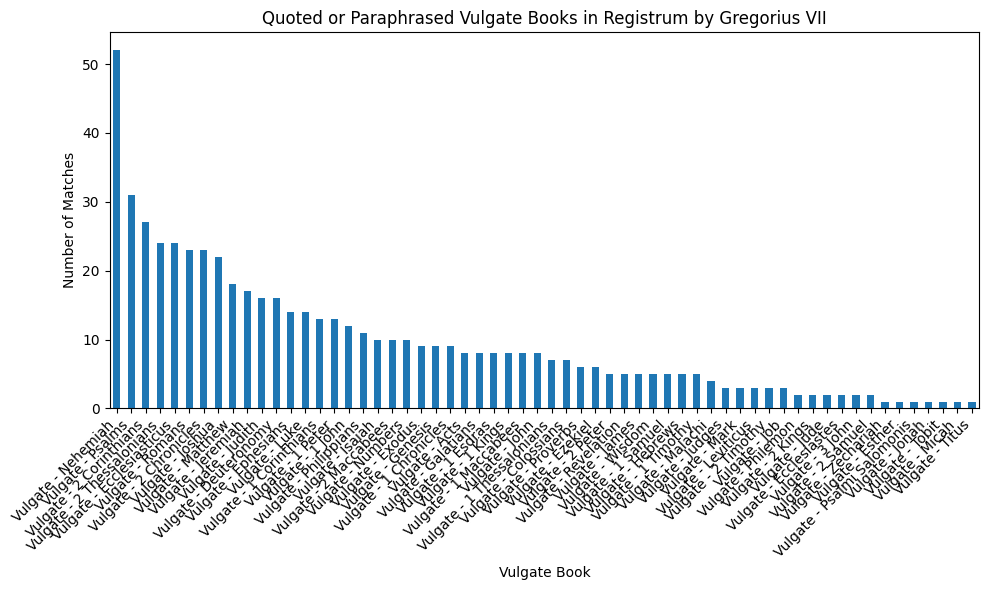

In [46]:
# Filter only matched rows (non-null vulgate_title)
matched = register_df[register_df["vulgate_title"].notnull()]

# Count occurrences
title_counts = matched["vulgate_title"].value_counts()

# Plot
plt.figure(figsize=(10, 6))
title_counts.plot(kind="bar")
plt.xlabel("Vulgate Book")
plt.ylabel("Number of Matches")
plt.title("Quoted or Paraphrased Vulgate Books in Registrum by Gregorius VII")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [54]:
register_matches["citation"] = register_matches.apply(lambda row: row["vulgate_title"].rpartition(" - ")[2] + " " + row["vulgate_sentence_id"].rpartition("lat:")[2], axis=1)

In [55]:
register_matches.sort_values("score", ascending=False, inplace=True)

In [57]:
register_matches = register_matches[['sentence_id', 'text', 'vulgate_text', 'score', 'citation', 'vulgate_sentence_id']]
register_matches.head(10)

,sentence_id,text,vulgate_text,score,citation,vulgate_sentence_id
2412,cc_10265_2412,"#posui te hodie super gentes et regna ut euellas, et destruas, et disperdas, et dissipes, et aedifices, et plantes (jer.",ecce constitui te hodie super gentes et super regna ut evellas et destruas et disperdas et dissipes et aedifices et plantes,0.899080,Jeremiah 1.10,vulgate_tlg0527.tlg049.obi-lat:1.10
3489,cc_10265_3489,"#quoniam data est a Domino potestas uobis, et uirtus ab Altissimo, qui interrogabit opera uestra, et cogitationes scrutabitur;",quoniam data est a Domino potestas vobis et virtus ab Altissimo qui interrogabit opera vestra et cogitationes scrutabitur,0.866035,Wisdom 6.4,vulgate_tlg0527.tlg033.obi-lat:6.4
3480,cc_10265_3480,"His quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerunt, uitam aeternam;",his quidem qui secundum patientiam boni operis gloriam et honorem et incorruptionem quaerentibus vitam aeternam,0.865040,Romans 2.7,vulgate_tlg0031.tlg006.obi-lat:2.7
5322,cc_10265_5322,"#tu es Petrus et super hanc petram aedificabo Ecclesiam meam, et portae inferi non praeualebunt aduersus eam;",et ego dico tibi quia tu es Petrus et super hanc petram aedificabo ecclesiam meam et portae inferi non praevalebunt adversum eam,0.860747,Matthew 16.18,vulgate_tlg0031.tlg001.obi-lat:16.18
3823,cc_10265_3823,"#secundum multitudinem dolorum meorum in corde meo, consolationes tuae, Domine, laetificauerunt animam meam (psal.",secundum multitudinem dolorum meorum in corde meo consolationes tuae laetificaverunt animam meam,0.856230,Psalms 93.19,vulgate_tlg0527.tlg027.obi-lat:93.19
394,cc_10265_394,"#christus semel pro peccatis nostris mortuus est, justus pro injustis, ut nos offerret Deo, mortificatos quidem carne, uiuificatos autem spiritu (petr.",quia et Christus semel pro peccatis mortuus est iustus pro iniustis ut nos offerret Deo mortificatus carne vivificatus autem spiritu,0.845510,1 Peter 3.18,vulgate_tlg0031.tlg021.obi-lat:3.18
1883,cc_10265_1883,"#ego pro te rogaui, Petre, ut non deficiat fides tua, et tu aliquando conuersus confirma fratres tuos (luc.",ego autem rogavi pro te ut non deficiat fides tua et tu aliquando conversus confirma fratres tuos,0.844021,Luke 22.32,vulgate_tlg0031.tlg003.obi-lat:22.32
326,cc_10265_326,"#si tradidero corpus meum ita ut ardeam, et si dedero omnes facultates meas in cibos pauperum, charitatem non habens, nihil sum (i Cor.",et si distribuero in cibos pauperum omnes facultates meas et si tradidero corpus meum ut ardeam caritatem autem non habuero nihil mihi prodest,0.832657,1 Corinthians 13.3,vulgate_tlg0031.tlg007.obi-lat:13.3
4081,cc_10265_4081,"#quoniam Domini est regnum, et ipse dominabitur gentium (psal.",quoniam Dei est regnum et % ipse ; dominabitur gentium,0.829683,Psalms 21.29,vulgate_tlg0527.tlg027.obi-lat:21.29
5336,cc_10265_5336,"#tu es Petrus, et super hanc petram aedificabo Ecclesiam meam, et portae inferi non praeualebunt aduersus eam, et tibi dabo claues regni coelorum (matth.",et ego dico tibi quia tu es Petrus et super hanc petram aedificabo ecclesiam meam et portae inferi non praevalebunt adversum eam,0.825101,Matthew 16.18,vulgate_tlg0031.tlg001.obi-lat:16.18


In [58]:
set_with_dataframe(grela_gs.add_worksheet("grela_register_matches_v1", 1,1), register_matches)